In [1]:
from pandas import Series, DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
import warnings
warnings.simplefilter('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Data Management

In [2]:
data = pd.read_csv("tree_addhealth.csv")

#upper-case all DataFrame column names
data.columns = map(str.upper, data.columns)

# Data Management

data_clean = data.dropna()

# subset clustering variables
cluster=data_clean[['ALCEVR1','MAREVER1','ALCPROBS1','DEVIANT1','VIOL1',
'DEP1','ESTEEM1','SCHCONN1','PARACTV', 'PARPRES','FAMCONCT']]
cluster.describe()

,ALCEVR1,MAREVER1,ALCPROBS1,DEVIANT1,VIOL1,DEP1,ESTEEM1,SCHCONN1,PARACTV,PARPRES,FAMCONCT
count,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000,4575.000000
mean,0.527432,0.241967,0.369180,2.645027,1.618579,8.537049,40.952131,28.360656,6.290710,13.398033,22.570557
std,0.499302,0.428321,0.894947,3.520554,2.593230,6.571052,5.381439,5.156385,3.360219,2.085837,2.614754
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,6.000000,0.000000,3.000000,6.300000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,38.000000,25.000000,4.000000,12.000000,21.700000
50%,1.000000,0.000000,0.000000,1.000000,0.000000,7.000000,40.000000,29.000000,6.000000,14.000000,23.700000
75%,1.000000,0.000000,0.000000,4.000000,2.000000,12.000000,45.000000,32.000000,9.000000,15.000000,24.300000
max,1.000000,1.000000,6.000000,27.000000,19.000000,48.000000,50.000000,38.000000,18.000000,15.000000,25.000000


In [3]:
# standardize clustering variables to have mean=0 and sd=1
clustervar=cluster.copy()
clustervar['ALCEVR1']=preprocessing.scale(clustervar['ALCEVR1'].astype('float64'))
clustervar['ALCPROBS1']=preprocessing.scale(clustervar['ALCPROBS1'].astype('float64'))
clustervar['MAREVER1']=preprocessing.scale(clustervar['MAREVER1'].astype('float64'))
clustervar['DEP1']=preprocessing.scale(clustervar['DEP1'].astype('float64'))
clustervar['ESTEEM1']=preprocessing.scale(clustervar['ESTEEM1'].astype('float64'))
clustervar['VIOL1']=preprocessing.scale(clustervar['VIOL1'].astype('float64'))
clustervar['DEVIANT1']=preprocessing.scale(clustervar['DEVIANT1'].astype('float64'))
clustervar['FAMCONCT']=preprocessing.scale(clustervar['FAMCONCT'].astype('float64'))
clustervar['SCHCONN1']=preprocessing.scale(clustervar['SCHCONN1'].astype('float64'))
clustervar['PARACTV']=preprocessing.scale(clustervar['PARACTV'].astype('float64'))
clustervar['PARPRES']=preprocessing.scale(clustervar['PARPRES'].astype('float64'))

## k-means cluster analysis for 1-9 clusters

In [4]:
# split data into train and test sets
clus_train, clus_test = train_test_split(clustervar, test_size=.3, random_state=123)

# k-means cluster analysis for 1-9 clusters                                                           
from scipy.spatial.distance import cdist
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) 
    / clus_train.shape[0])

## Plot average distance from observations from the cluster centroid

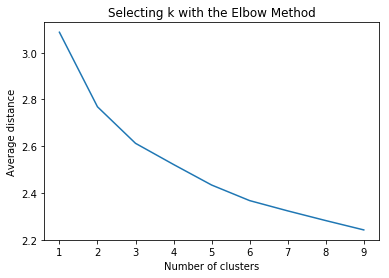

In [5]:
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')
plt.show()

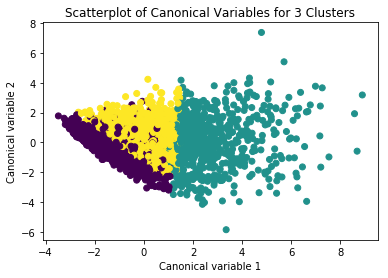

In [6]:
# Interpret 3 cluster solution
model3=KMeans(n_clusters=3)
model3.fit(clus_train)
clusassign=model3.predict(clus_train)

# plot clusters
from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model3.labels_,)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 Clusters')
plt.show()

## Merge cluster assignment with clustering variables

In [7]:
# create a unique identifier variable from the index for the 
# cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level=0, inplace=True)
# create a list that has the new index variable
cluslist=list(clus_train['index'])
# create a list of cluster assignments
labels=list(model3.labels_)
# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))

# convert newlist dictionary to a dataframe
newclus=DataFrame.from_dict(newlist, orient='index')

# rename the cluster assignment column
newclus.columns = ['cluster']

In [8]:
# now do the same for the cluster assignment variable
# create a unique identifier variable from the index for the 
# cluster assignment dataframe 
# to merge with cluster training data
newclus.reset_index(level=0, inplace=True)
# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(clus_train, newclus, on='index')
merged_train.head(n=100)
# cluster frequencies
merged_train.cluster.value_counts()

0    1419
2    1106
1     677
Name: cluster, dtype: int64

## Calculating clustering variable means by cluster

In [9]:
# FINALLY calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
               index   ALCEVR1  MAREVER1  ALCPROBS1  DEVIANT1     VIOL1  \
cluster                                                                   
0        3238.273432 -1.056455 -0.474480  -0.412562 -0.450899 -0.264110   
1        3321.251108  0.659572  1.080176   0.879917  1.084830  0.781704   
2        3325.385172  0.946562 -0.049857  -0.048816 -0.111833 -0.164638   

             DEP1   ESTEEM1  SCHCONN1   PARACTV   PARPRES  FAMCONCT  
cluster                                                              
0       -0.292501  0.209016  0.342973  0.091971  0.156849  0.299811  
1        0.854388 -0.668598 -0.942608 -0.417569 -0.489015 -0.967216  
2       -0.200223  0.196253  0.141892  0.156748  0.110018  0.235393  


## Validating clusters in training data by examining cluster differences in GPA using ANOVA

In [10]:
# validate clusters in training data by examining cluster differences in GPA using ANOVA
# first have to merge GPA with clustering variables and cluster assignment data 
gpa_data=data_clean['GPA1']
# split GPA data into train and test sets
gpa_train, gpa_test = train_test_split(gpa_data, test_size=.3, random_state=123)
gpa_train1=pd.DataFrame(gpa_train)
gpa_train1.reset_index(level=0, inplace=True)
merged_train_all=pd.merge(gpa_train1, merged_train, on='index')
sub1 = merged_train_all[['GPA1', 'cluster']].dropna()

In [11]:
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

gpamod = smf.ols(formula='GPA1 ~ C(cluster)', data=sub1).fit()
print (gpamod.summary())

                            OLS Regression Results                            
Dep. Variable:                   GPA1   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     135.1
Date:                Tue, 20 Feb 2018   Prob (F-statistic):           4.87e-57
Time:                        00:29:24   Log-Likelihood:                -3597.6
No. Observations:                3202   AIC:                             7201.
Df Residuals:                    3199   BIC:                             7219.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           2.9951      0.020    1

In [12]:
print ('means for GPA by cluster')
m1= sub1.groupby('cluster').mean()
print (m1)

means for GPA by cluster
             GPA1
cluster          
0        2.995067
1        2.424052
2        2.831751


In [13]:
print ('standard deviations for GPA by cluster')
m2= sub1.groupby('cluster').std()
print (m2)

standard deviations for GPA by cluster
             GPA1
cluster          
0        0.738169
1        0.783263
2        0.728352


In [14]:
mc1 = multi.MultiComparison(sub1['GPA1'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  0      1     -0.571  -0.6526 -0.4895  True 
  0      2    -0.1633  -0.2333 -0.0933  True 
  1      2     0.4077   0.3225  0.4929  True 
---------------------------------------------
